# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on mouse PFC cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [2]:
import numpy as np
import scanpy as sc
import anndata

import time
import os, wget

import cupy as cp
import cupyx as cpx
import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
from sh import gunzip
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import rmm

# managed_memory オプションなどで RMM を初期化
rmm.reinitialize(managed_memory=True)

from rmm.allocators.cupy import rmm_cupy_allocator
import cupy
cupy.cuda.set_allocator(rmm_cupy_allocator)

import calculation_tool as ct
import gc

gc.collect()
cp.get_default_memory_pool().free_all_blocks()

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [ ]:
import os
import urllib.request
import gzip
import shutil

url_list=[r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482102&format=file&file=GSM5482102%5FPFC%5FWT%5FRep1%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482102&format=file&file=GSM5482102%5FPFC%5FWT%5FRep1%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482102&format=file&file=GSM5482102%5FPFC%5FWT%5FRep1%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482103&format=file&file=GSM5482103%5FPFC%5FWT%5FRep2%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482103&format=file&file=GSM5482103%5FPFC%5FWT%5FRep2%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482103&format=file&file=GSM5482103%5FPFC%5FWT%5FRep2%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482104&format=file&file=GSM5482104%5FPFC%5FSetd1aHet%5FRep1%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482104&format=file&file=GSM5482104%5FPFC%5FSetd1aHet%5FRep1%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482104&format=file&file=GSM5482104%5FPFC%5FSetd1aHet%5FRep1%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482105&format=file&file=GSM5482105%5FPFC%5FSetd1aHet%5FRep2%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482105&format=file&file=GSM5482105%5FPFC%5FSetd1aHet%5FRep2%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482105&format=file&file=GSM5482105%5FPFC%5FSetd1aHet%5FRep2%5Fmatrix%2Emtx%2Egz"]

def download_file(url, dir, file_name):
    full_path = os.path.join(dir, file_name)
    urllib.request.urlretrieve(url, full_path)
    # 以下のコメントアウト部分を活用する場合は、解凍の手順を追加することができます。
    # with gzip.open(full_path, 'rb') as f_in:
    #     with open(full_path[:-3], 'wb') as f_out:
    #         shutil.copyfileobj(f_in, f_out)

dir = "/data/mouse_PFC/"

for url in url_list:
    acc = url.split("acc=")[1].split("&")[0]
    file_name_from_url = url.split("file=")[1]

    # WTとSetd1aHetのサブフォルダを作成
    subfolder = "WT" if "WT" in file_name_from_url else "Setd1aHet"
    acc_dir = os.path.join(dir,subfolder, acc)
    os.makedirs(acc_dir, exist_ok=True)

    # 標準的なファイル名に変更（.gzを取り除く）
    standard_file_name = file_name_from_url.split('_')[-1].replace('.gz', '')
    
    if "barcodes" in file_name_from_url:
        standard_file_name = "barcodes.tsv.gz"
    elif "features" in file_name_from_url:
        standard_file_name = "features.tsv.gz"
    elif "matrix" in file_name_from_url:
        standard_file_name = "matrix.mtx.gz"
    
    # ファイルをダウンロード
    download_file(url, acc_dir, standard_file_name)


In [ ]:
# ダウンロードディレクトリ
base_dir = "/data/mouse_PFC/"

def read_10x_mtx(path, label):
    """10x mtxフォーマットのデータを読み込み、指定されたラベルを追加します。"""
    adata = sc.read_10x_mtx(
        path,
        var_names='gene_symbols',
        cache=True
    )
    adata.obs['label'] = label
    return adata

labels = ["WT", "Setd1aHet"]

all_adatas = []

for label in labels:
    label_dir = os.path.join(base_dir, label)
    gsm_dirs = [os.path.join(label_dir, d) for d in os.listdir(label_dir) if os.path.isdir(os.path.join(label_dir, d))]
    
    for gsm_dir in gsm_dirs:
        if os.path.exists(gsm_dir):
            all_adatas.append(read_10x_mtx(gsm_dir, label))

# 全てのAnnDataオブジェクトを1つに結合
combined_adata = all_adatas[0].concatenate(all_adatas[1:], join='outer')

# .h5ad形式で保存
combined_adata.write("/data/mouse_PFC/combined_data.h5ad")

## load data

In [ ]:
file_path="/data/mouse_PFC/combined_data.h5ad"
#adata.write(file_path)
adata = anndata.read_h5ad(file_path)
adata.X.dtype

In [4]:
import gc
import cupy as cp
gc.collect()
cp.get_default_memory_pool().free_all_blocks()

preprocess_in_bulk
HTR1E is not included
HTR1E is removed from marker list
DRD3 is not included
DRD3 is removed from marker list
CHRM4 is not included
CHRM4 is removed from marker list
ADRA2B is not included
ADRA2B is removed from marker list
['CX3CR1', 'CLDN5', 'GLUL', 'NDRG2', 'PCDH15', 'PLP1', 'MBP', 'SATB2', 'SLC17A7', 'SLC17A6', 'GAD2', 'GAD1', 'SNAP25', 'HTR1A', 'HTR1B', 'HTR1D', 'HTR2A', 'HTR2B', 'HTR2C', 'HTR3A', 'HTR4', 'HTR5A', 'HTR6', 'HTR7', 'DRD1', 'DRD2', 'DRD4', 'DRD5', 'HRH1', 'HRH2', 'HRH3', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM5', 'ADRA1A', 'ADRA1B', 'ADRA2A', 'ADRA2C', 'ADRB1', 'ADRB2']
perform regression
perform scale
float32
Total Preprocessing time: 269.52388095855713
shape of adata: (27469, 21673)
shape of adata: (27469, 21673)
perform PCA
40
t-sne
UMAP
UMAP louvain


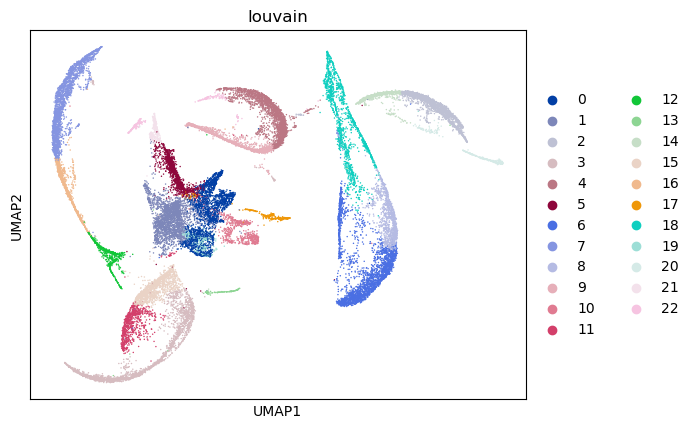

UMAP leiden


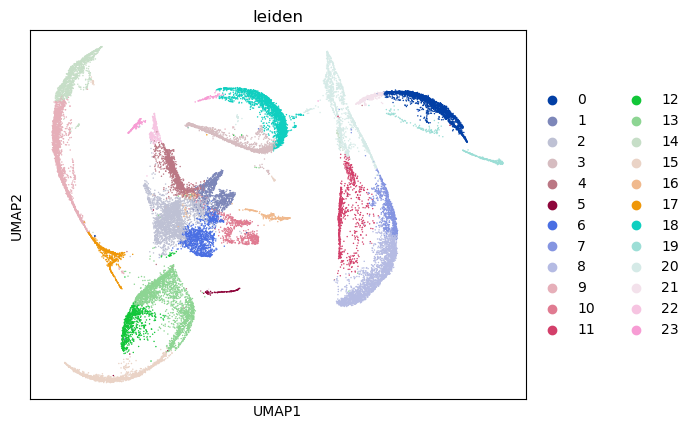

calc drug response
clz selective cells
# of clz selective cells: is_clz_selective
False    27123
True       346
Name: count, dtype: int64


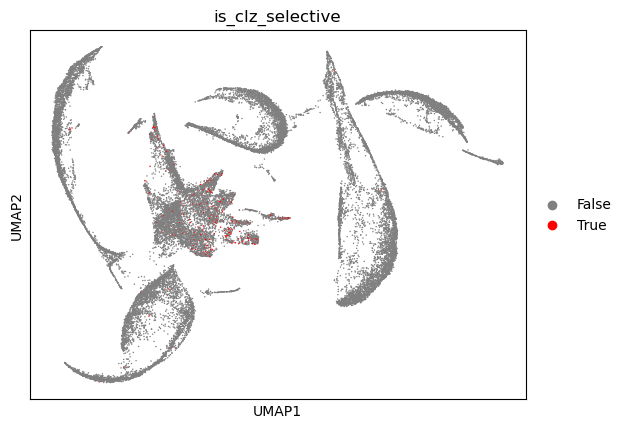

In [5]:
import calculation_tool as ct
file_path="/data/mouse_PFC/combined_data.h5ad"
adata,GPCR_df=ct.preprocess_adata_in_bulk(file_path,label=None)
GPCR_df.to_csv("/data/mouse_PFC/combined_data_GPCR_df.csv")

In [8]:
import calculation_tool as ct
D_R_mtx,GPCR_type_df,drug_list,GPCR_list=ct.load_parameters()
params=ct.set_parameters_for_preprocess(GPCR_list)

In [ ]:
file_path="/temp/data/mouse_PFC/combined_data_processed.h5ad"
adata=anndata.read_h5ad(file_path)

In [6]:
def calc_drug_response(adata,GPCR_df,GPCR_type_df,drug_list,D_R_mtx,drug_conc):
    #noramlize GPCR expression levels
    GPCR_adata=anndata.AnnData(X=GPCR_df)
    GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']
    GPCR_adata_norm_df=pd.DataFrame(GPCR_adata_norm,columns=GPCR_adata.var.index)
    norm_df=pd.DataFrame(GPCR_adata_norm)
    norm_col=[str[:-4] for str in GPCR_df.columns]
    norm_df.columns=norm_col
    
    GPCR_type_df=GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)]
    
    Gs=GPCR_type_df[GPCR_type_df.type=="Gs"]["receptor_name"].values
    Gi=GPCR_type_df[GPCR_type_df.type=="Gi"]["receptor_name"].values
    Gq=GPCR_type_df[GPCR_type_df.type=="Gq"]["receptor_name"].values
    
    cAMP_df=pd.DataFrame(columns=drug_list)
    #Ca_df=pd.DataFrame(columns=drug_list)
    #drug_conc=D_R_mtx.median().median()*100
    for drug in drug_list:
        Gs_effect=(norm_df.loc[:,Gs]/(1+drug_conc/D_R_mtx.loc[drug,Gs])).sum(axis=1) #TODO ki値で割り算するときにlog換算すべきか
        Gi_effect=(norm_df.loc[:,Gi]/(1+drug_conc/D_R_mtx.loc[drug,Gi])).sum(axis=1)
        basal_cAMP=(norm_df.loc[:,Gs]-norm_df.loc[:,Gi]).sum(axis=1)
        #Gq_effect=(norm_df.loc[:,Gq]/D_R_mtx.loc[drug,Gq]).sum(axis=1)
        cAMPmod=(Gs_effect-Gi_effect)-basal_cAMP #Giの阻害→cAMP上昇、Gsの阻害→cAMP低下

        #Gs_effect=(norm_df.loc[:,Gs]/D_R_mtx.loc[drug,Gs]).sum(axis=1) 
        #Gi_effect=(norm_df.loc[:,Gi]/D_R_mtx.loc[drug,Gi]).sum(axis=1)
        #cAMPmod=Gi_effect-Gs_effect
        #Camod=-Gq_effect #Gq阻害→Ca低下
        cAMP_df[drug]=cAMPmod
        #Ca_df[drug]=Camod
        
    cAMP_df.index=adata.obs_names
    #Ca_df.index=adata.obs_names
    #Ca_df=Ca_df+10**(-4)
    for drug in drug_list:
        adata.obs['cAMP_%s'%drug]=cAMP_df[drug]
        #adata.obs['Ca_%s'%drug]=Ca_df[drug]
        
    return adata


def calc_drug_response_old(adata,GPCR_df,GPCR_type_df,drug_list,D_R_mtx,drug_conc):
    #noramlize GPCR expression levels
    GPCR_adata=anndata.AnnData(X=GPCR_df)
    GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']
    GPCR_adata_norm_df=pd.DataFrame(GPCR_adata_norm,columns=GPCR_adata.var.index)
    norm_df=pd.DataFrame(GPCR_adata_norm)
    norm_col=[str[:-4] for str in GPCR_df.columns]
    norm_df.columns=norm_col
    
    GPCR_type_df=GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)]
    
    Gs=GPCR_type_df[GPCR_type_df.type=="Gs"]["receptor_name"].values
    Gi=GPCR_type_df[GPCR_type_df.type=="Gi"]["receptor_name"].values
    Gq=GPCR_type_df[GPCR_type_df.type=="Gq"]["receptor_name"].values
    
    cAMP_df=pd.DataFrame(columns=drug_list)
    #Ca_df=pd.DataFrame(columns=drug_list)
    #drug_conc=D_R_mtx.median().median()*100
    for drug in drug_list:
        #Gs_effect=(norm_df.loc[:,Gs]/(1+drug_conc/D_R_mtx.loc[drug,Gs])).sum(axis=1) #TODO ki値で割り算するときにlog換算すべきか
        #Gi_effect=(norm_df.loc[:,Gi]/(1+drug_conc/D_R_mtx.loc[drug,Gi])).sum(axis=1)
        #basal_cAMP=(norm_df.loc[:,Gs]-norm_df.loc[:,Gi]).sum(axis=1)
        #Gq_effect=(norm_df.loc[:,Gq]/D_R_mtx.loc[drug,Gq]).sum(axis=1)
        #cAMPmod=(Gs_effect-Gi_effect)-basal_cAMP #Giの阻害→cAMP上昇、Gsの阻害→cAMP低下

        Gs_effect=(norm_df.loc[:,Gs]/D_R_mtx.loc[drug,Gs]).sum(axis=1) 
        Gi_effect=(norm_df.loc[:,Gi]/D_R_mtx.loc[drug,Gi]).sum(axis=1)
        cAMPmod=Gi_effect-Gs_effect
        #Camod=-Gq_effect #Gq阻害→Ca低下
        cAMP_df[drug]=cAMPmod
        #Ca_df[drug]=Camod
        
    cAMP_df.index=adata.obs_names
    #Ca_df.index=adata.obs_names
    #Ca_df=Ca_df+10**(-4)
    for drug in drug_list:
        adata.obs['cAMP_%s'%drug]=cAMP_df[drug]
        #adata.obs['Ca_%s'%drug]=Ca_df[drug]
        
    return adata

def calc_clz_selective_cell(adata,drug_list,selectivity_threshold):
    adata.obs["is_clz_activated"]=np.zeros(len(adata.obs))
    adata.obs["is_clz_activated"][adata.obs["cAMP_CLOZAPINE"]>10]=1
    adata.obs["is_clz_activated"]=adata.obs["is_clz_activated"].astype("category")
    
    adata.obs["is_clz_inhibited"]=np.zeros(len(adata.obs))
    adata.obs["is_clz_inhibited"][adata.obs["cAMP_CLOZAPINE"]<-10]=1
    adata.obs["is_clz_inhibited"]=adata.obs["is_clz_inhibited"].astype("category")

    # 「CLOZAPINE」以外の薬に対応するカラム名のリストを作成
    drug_cols = [f"cAMP_{drug}" for drug in drug_list if drug != "CLOZAPINE"]

    # メモリ使用量削減のため、必要に応じて計算対象カラムを float32 にキャスト
    for col in drug_cols + ["cAMP_CLOZAPINE"]:
        adata.obs[col] = adata.obs[col].astype("float32")


    # ゼロ除算を避けるための小さな定数
    epsilon = 1e-9

    # 薬ごとの cAMP 値の平均（ゼロ除算防止のため epsilon を加算）
    adata.obs["cAMP_mean_other_than_czp"] = adata.obs[drug_cols].mean(axis=1) + epsilon


    # クロザピンに対するセレクティビティの計算（各細胞ごとにベクトル演算）
    adata.obs["cAMP_clz_selectivity"] = (adata.obs["cAMP_CLOZAPINE"] ** 2) / (adata.obs["cAMP_mean_other_than_czp"] ** 2)

    # selectivity_threshold と cAMP_CLOZAPINE > 0 の条件を満たす細胞をカテゴリ型でラベル付け
    adata.obs["is_clz_selective"] = (((adata.obs["cAMP_clz_selectivity"] > selectivity_threshold) & 
                                    (adata.obs["cAMP_CLOZAPINE"] > 0))
                                    ).astype("category")
    
    print("clz selective cells")
    print("# of clz selective cells:",adata.obs["is_clz_selective"].value_counts())
    num_clz_selective = adata.obs["is_clz_selective"].value_counts()[True]
    sc.pl.umap(adata, color=["is_clz_selective"],palette=["gray", "red"])
    return adata,num_clz_selective

Drug concentration: 0.001
clz selective cells
# of clz selective cells: is_clz_selective
False    27391
True        78
Name: count, dtype: int64


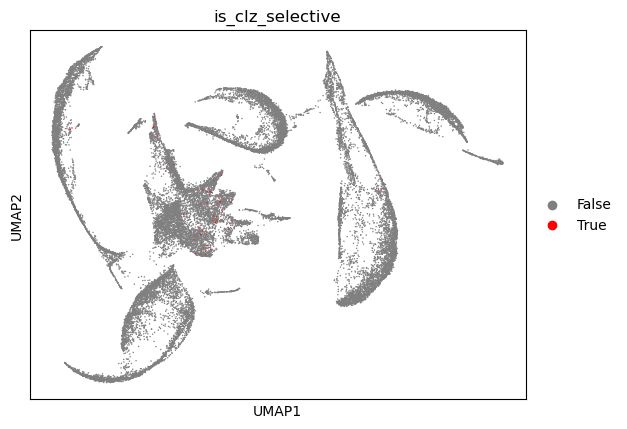

Drug concentration: 0.01
clz selective cells
# of clz selective cells: is_clz_selective
False    27391
True        78
Name: count, dtype: int64


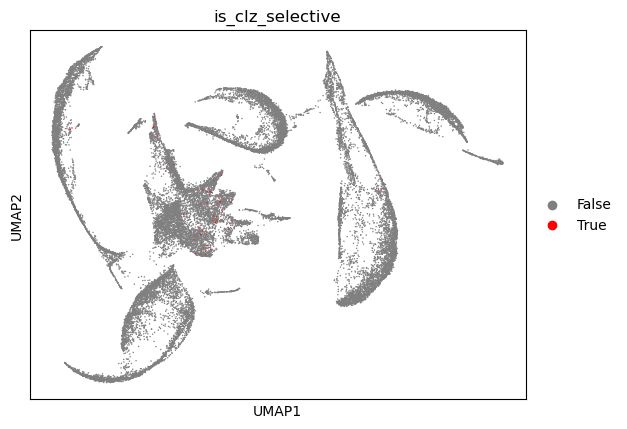

Drug concentration: 0.1
clz selective cells
# of clz selective cells: is_clz_selective
False    27391
True        78
Name: count, dtype: int64


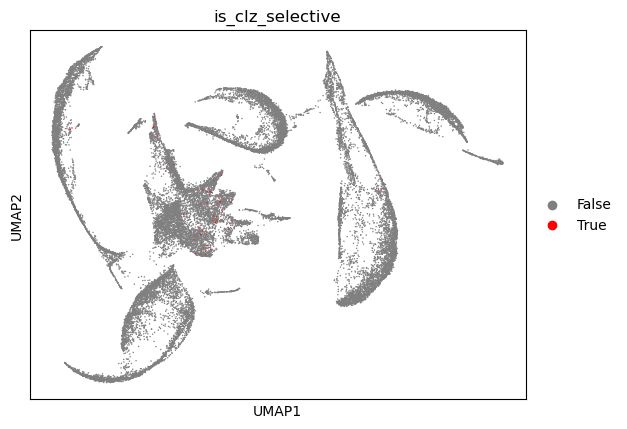

Drug concentration: 1
clz selective cells
# of clz selective cells: is_clz_selective
False    27385
True        84
Name: count, dtype: int64


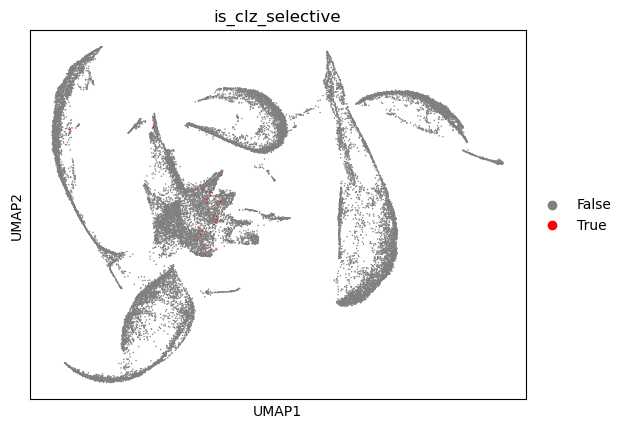

Drug concentration: 1.5848931924611136
clz selective cells
# of clz selective cells: is_clz_selective
False    27378
True        91
Name: count, dtype: int64


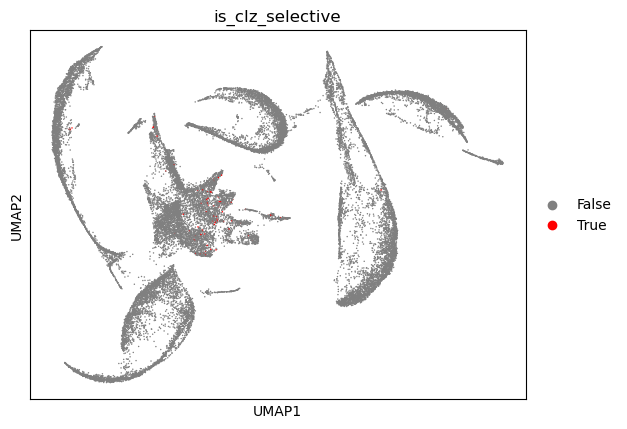

Drug concentration: 2.2387211385683394
clz selective cells
# of clz selective cells: is_clz_selective
False    27376
True        93
Name: count, dtype: int64


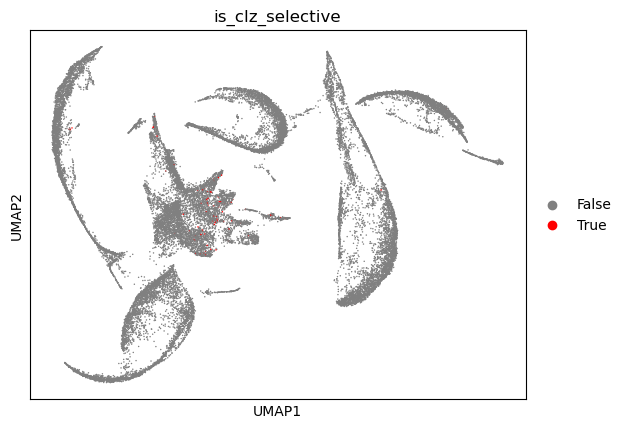

Drug concentration: 3.1622776601683795
clz selective cells
# of clz selective cells: is_clz_selective
False    27219
True       250
Name: count, dtype: int64


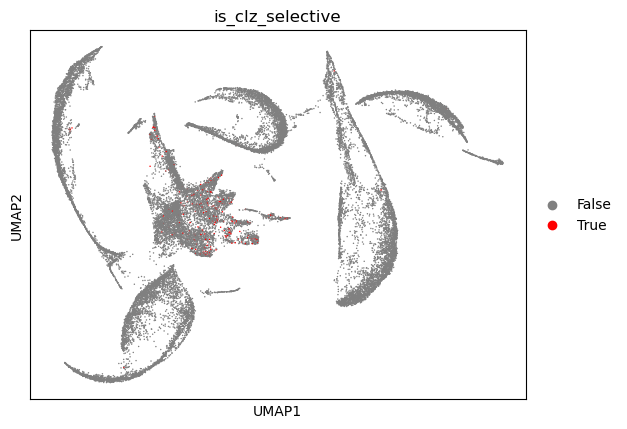

Drug concentration: 5.623413251903491
clz selective cells
# of clz selective cells: is_clz_selective
False    27177
True       292
Name: count, dtype: int64


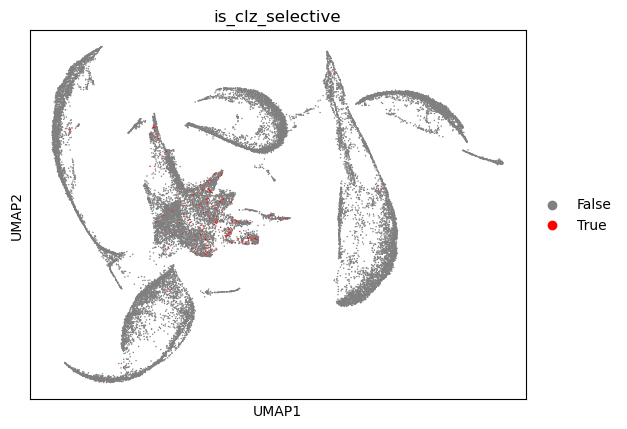

Drug concentration: 10
clz selective cells
# of clz selective cells: is_clz_selective
False    27169
True       300
Name: count, dtype: int64


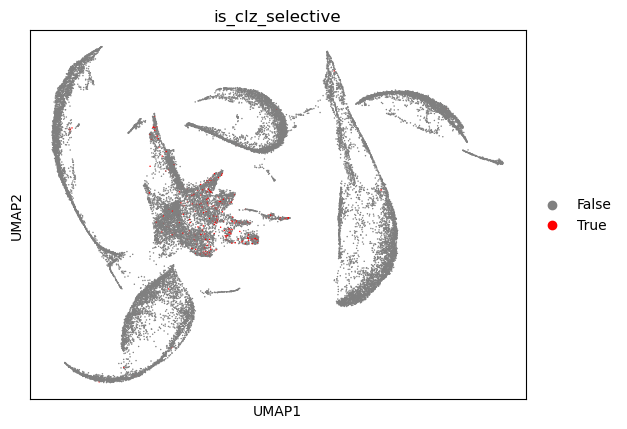

Drug concentration: 31.622776601683793
clz selective cells
# of clz selective cells: is_clz_selective
False    27158
True       311
Name: count, dtype: int64


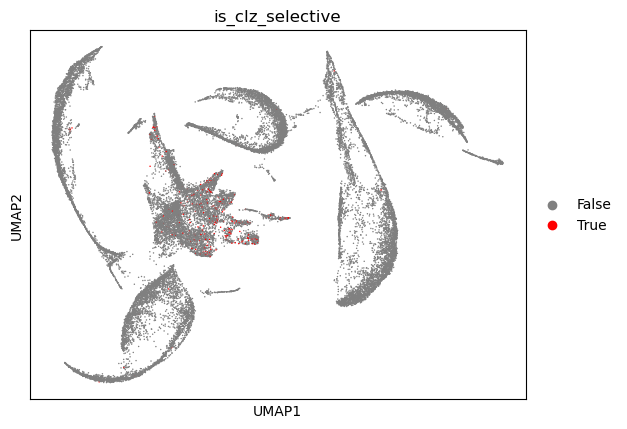

Drug concentration: 100
clz selective cells
# of clz selective cells: is_clz_selective
False    27135
True       334
Name: count, dtype: int64


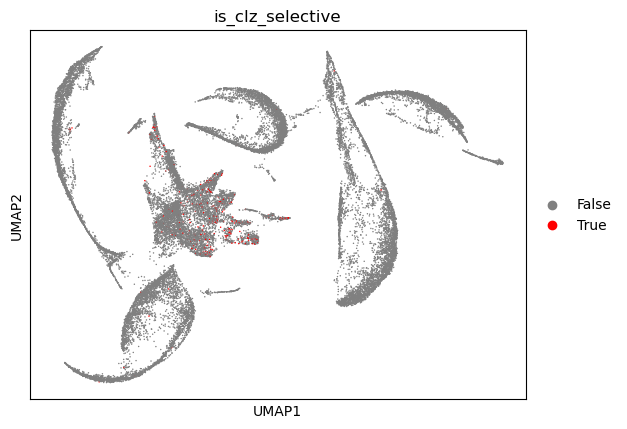

Drug concentration: 316.22776601683796
clz selective cells
# of clz selective cells: is_clz_selective
False    27133
True       336
Name: count, dtype: int64


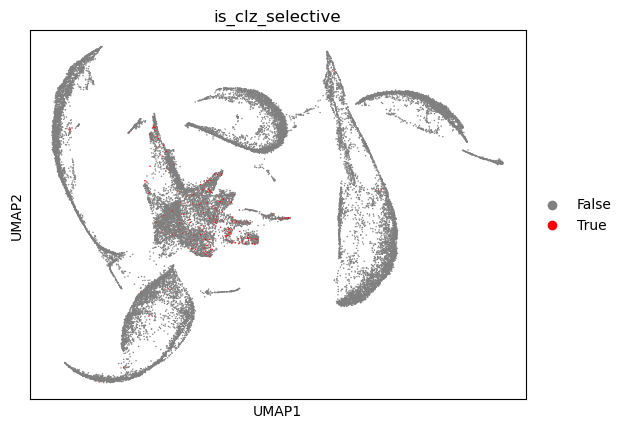

Drug concentration: 1000
clz selective cells
# of clz selective cells: is_clz_selective
False    27142
True       327
Name: count, dtype: int64


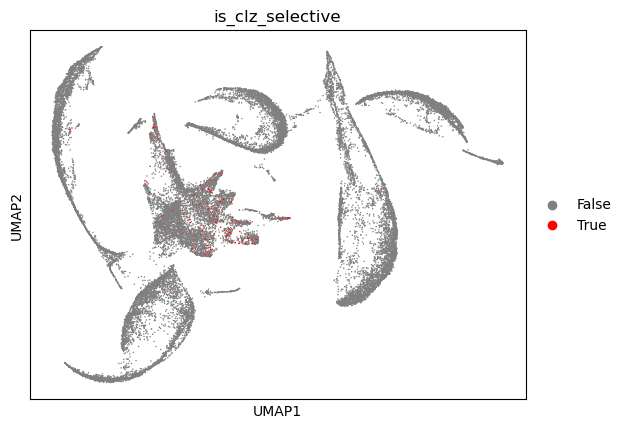

Drug concentration: 10000
clz selective cells
# of clz selective cells: is_clz_selective
False    27201
True       268
Name: count, dtype: int64


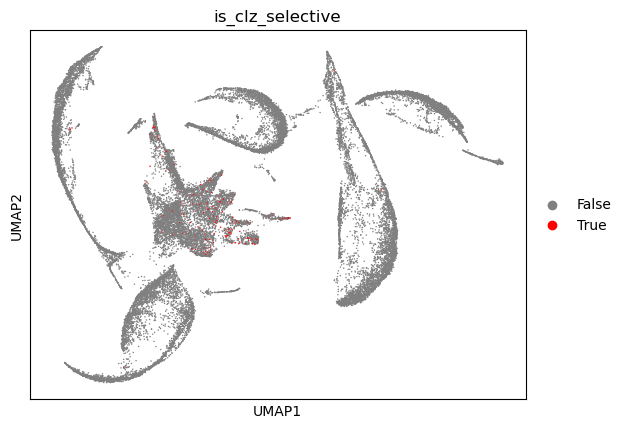

Drug concentration: 100000
clz selective cells
# of clz selective cells: is_clz_selective
False    27257
True       212
Name: count, dtype: int64


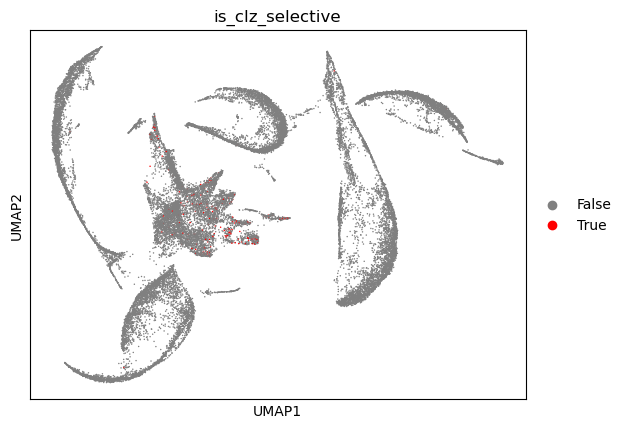

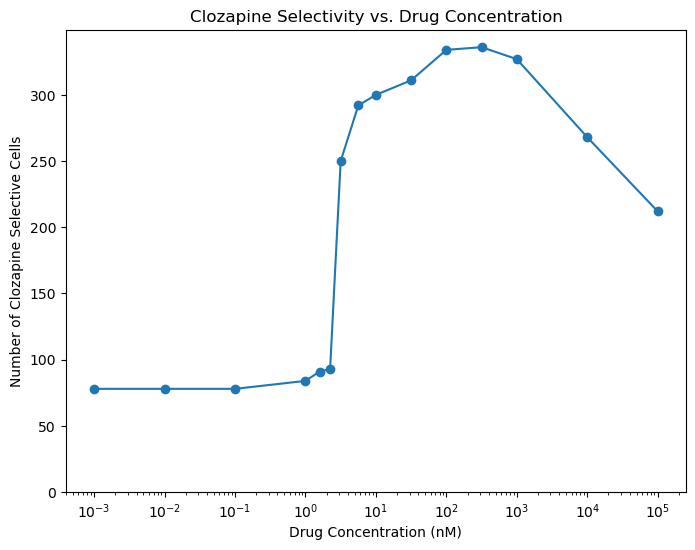

In [9]:
import bisect
# べき指数が -3 から +5 までのリスト（必要に応じて変更）
powers = [i for i in range(-3, 6)]
bisect.insort(powers, 0.2)
bisect.insort(powers, 0.35)
bisect.insort(powers, 0.5)
bisect.insort(powers, 0.75)
#bisect.insort(powers, 1.2)
bisect.insort(powers, 1.5)
bisect.insort(powers, 2.5)

# 10のべき乗の値をリストにする（薬剤濃度リスト）
drug_conc_list = [10**i for i in powers]

# 各濃度におけるクロザピン選択細胞数を格納するリスト
num_clz_list = []

for drug_conc in drug_conc_list:
    print("Drug concentration:", drug_conc)
    # 薬剤反応の計算（関数の実装に依存）
    adata = calc_drug_response(adata, GPCR_df, GPCR_type_df, drug_list, D_R_mtx, drug_conc)
    # クロザピン選択細胞の計算（この関数は adata と num_clz_selective を返すと仮定）
    adata, num_clz_selective = calc_clz_selective_cell(adata, drug_list, selectivity_threshold=1.5)
    num_clz_list.append(num_clz_selective)

# プロット
plt.figure(figsize=(8, 6))
plt.plot(drug_conc_list, num_clz_list, marker='o', linestyle='-')
plt.xscale('log')  # x軸を対数スケールに設定
plt.xlabel("Drug Concentration (nM)")
plt.ylabel("Number of Clozapine Selective Cells")
plt.title("Clozapine Selectivity vs. Drug Concentration")
plt.ylim(bottom=0) 
#plt.grid(True)
plt.show()

In [ ]:
sc.pl.violin(
    adata,
    keys=['cAMP_CLOZAPINE',"cAMP_RISPERIDONE","cAMP_HALOPERIDOL"],  # Y軸に表示する変数
    groupby='leiden',       # X軸に leiden クラスタを使用
    jitter=True,            # データ点のばらつきを表示（オプション）
    stripplot=False,         # ストリッププロットを追加（オプション）
    legend=False
    
)

In [ ]:
# is_clz_selective が True の細胞のみを抽出
selective_cells = adata.obs[adata.obs["is_clz_selective"] == True]

# 抽出した細胞群における label 列の割合を計算（normalize=True で割合に）
label_proportions = selective_cells["label"].value_counts(normalize=True)

# 結果の表示
print(label_proportions)

# 必要に応じて、個別の割合を変数に格納する例
wt_ratio = label_proportions.get("WT", 0)
Setd1aHet_ratio = label_proportions.get("Setd1aHet", 0)

print(f"WT の割合: {wt_ratio:.2f}")
print(f"Setd1aHet の割合: {Setd1aHet_ratio:.2f}")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# adata.obs から必要な列（leiden と cAMP_CLOZAPINE）を抽出
df = adata.obs[['leiden', 'cAMP_CLOZAPINE']].copy()

# boxプロットの作成
#sns.boxplot(x='leiden', y='cAMP_CLOZAPINE', data=df,showfliers=False)
sns.barplot(x='leiden', y='cAMP_CLOZAPINE', data=df)
plt.xlabel("Leiden Cluster")
plt.ylabel("cAMP_CLOZAPINE")
plt.title("Box Plot of cAMP_CLOZAPINE by Leiden Cluster")
plt.show()

In [ ]:
sc.pl.umap(adata, color=["cAMP_CLOZAPINE"], vmin=-1000, vmax=3000)
sc.pl.umap(adata, color=["cAMP_RISPERIDONE"], vmin=-1000, vmax=3000)
sc.pl.umap(adata, color=["cAMP_HALOPERIDOL"], vmin=-1000, vmax=3000)

In [ ]:
drug_conc=1*10**2
adata = calc_drug_response(adata, GPCR_df, GPCR_type_df, drug_list, D_R_mtx, drug_conc)
# クロザピン選択細胞の計算（この関数は adata と num_clz_selective を返すと仮定）
adata, num_clz_selective = calc_clz_selective_cell(adata, drug_list, selectivity_threshold=1.5)
file_path="/data/mouse_PFC/combined_data_drug_res_calculated.h5ad"
adata.write(file_path)

In [ ]:
file_path="/data/mouse_PFC/combined_data_drug_res_calculated.h5ad"
adata = anndata.read_h5ad(file_path)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
sc.pl.umap(adata, color=["leiden"])
# --- 事前準備 ---
# もし "leiden" がカテゴリ型でなければ、数値順（整数に変換してソート）でカテゴリに変換する
if not pd.api.types.is_categorical_dtype(adata.obs["leiden"]):
    leiden_order = sorted(adata.obs["leiden"].unique(), key=lambda x: int(x))
    adata.obs["leiden"] = pd.Categorical(adata.obs["leiden"], categories=leiden_order, ordered=True)

# leiden の順序（カテゴリ）を取得
cluster_order = adata.obs["leiden"].cat.categories

# sc.pl.umapで使われた色は通常 adata.uns["leiden_colors"] に格納されている
# ここでは、cluster_order の順番と対応していると仮定
colors = adata.uns.get("leiden_colors")
if colors is None:
    raise ValueError("adata.uns['leiden_colors'] が見つかりません。sc.tl.leiden などで設定してください。")

# クラスター毎の色の対応辞書を作成
cluster2color = dict(zip(cluster_order, colors))

# --- クロザピン選択細胞の割合の計算 ---
# "is_clz_selective" が bool でない場合、ブール値に変換（ここでは文字列比較を例示）
adata.obs["is_clz_selective_bool"] = adata.obs["is_clz_selective"].astype(str) == "True"

# 各クラスター内での True の割合を計算し、100倍してパーセントにする
clz_percentage = adata.obs.groupby("leiden")["is_clz_selective_bool"].mean() * 100

# クラスターの並び順を cluster_order に合わせる
clz_percentage = clz_percentage.reindex(cluster_order)

# --- 棒グラフの描画 ---
plt.figure(figsize=(8, 6))
# 各棒の色を cluster2color から取得して設定
bars = plt.bar(clz_percentage.index, clz_percentage.values,
               color=[cluster2color[cluster] for cluster in clz_percentage.index])

plt.xlabel("Leiden Cluster")
plt.ylabel("% of clz selective cell")
plt.title("Percentage of Clozapine Selective Cells per Leiden Cluster")
plt.ylim(bottom=0)  # y軸の下限を 0 に設定
plt.show()


In [ ]:
marker_genes_dict = {
    "Neuron": ["RBFOX3", "MAP2", "SLC17A7", "SATB2", "CUX2","BCL11B", "FEZF2","TLE4", "FOXP2","GAD1","PVALB","SST","VIP"],
    "Astrocyte": ["GFAP", "AQP4", "ALDH1L1"],
    "Oligodendrocyte": ["MBP", "MOG", "OLIG1", "OLIG2"],
    "Microglia": ["TMEM119", "AIF1", "CD68", "CX3CR1"],
    "Endothelial": ["CLDN5", "PECAM1", "VWF"],
    "OPC": ["PDGFRA", "CSPG4"],
    "Ependymal": ["FOXJ1"]
}
sc.pl.dotplot(adata, marker_genes_dict, "leiden")

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(correlation_matrix):
    plt.figure(figsize=(10, 8))  # 画像のサイズを調整します。
    
    # ヒートマップをプロット
    sns.heatmap(
        correlation_matrix, 
        annot=True,       # 数値をセル内に表示
        cmap='coolwarm',  # カラーマップの指定
        vmin=-1, vmax=1, # カラーバーの最小・最大値
        square=True,     # 各セルを正方形にする
        linewidths=.5    # セル間の線の幅
    )

    plt.title("Correlation Matrix")
    plt.show()

# 薬のリストからcAMPのデータカラムを抽出
cAMP_columns = ['cAMP_%s' % drug for drug in drug_list]

# adataのobsからcAMPデータを取得
cAMP_data = adata.obs[cAMP_columns]

# 相関を計算
correlation_matrix = cAMP_data.corr()

# ヒートマップのプロット
plot_correlation_matrix(correlation_matrix)

In [ ]:
sc.pl.umap(adata, color=["leiden"])

In [ ]:
sc.pl.umap(adata, color=["label"])

In [ ]:
import matplotlib.gridspec as gridspec
import math
import seaborn as sns
# 1. ラベル毎に処理するための準備
unique_labels = adata.obs['label'].unique()

# 2. 各ラベルについて、各クラスタの薬剤反応の相関行列を計算
drug_response_columns = ['cAMP_%s' % drug for drug in drug_list]

# ラベル毎の相関行列を保存するための辞書
correlation_matrices_per_label = {}

for label in unique_labels:
    adata_subset = adata[adata.obs["label"] == label]  # ラベルに基づいてadataのサブセットを取得
    
    # サブセット内のクラスタを取得
    clusters = adata_subset.obs['leiden'].cat.categories
    correlation_matrices = {}
    
    for cluster in clusters:
        subset = adata_subset.obs.loc[adata_subset.obs['leiden'] == cluster, drug_response_columns]
        correlation_matrices[cluster] = subset.corr()
    
    correlation_matrices_per_label[label] = correlation_matrices

# 3. 各ラベルの相関行列を1つのFigureにまとめてプロット
for label, correlation_matrices in correlation_matrices_per_label.items():
    num_clusters = len(correlation_matrices)
    
    # 4つのクラスタごとに新しい行を作成する
    rows = math.ceil(num_clusters / 4)
    fig = plt.figure(figsize=(40, rows * 10))  # 1つの相関行列あたりの横幅を10として計算
    spec = gridspec.GridSpec(rows, 4, figure=fig)  # 4列のグリッドを作成
    
    for i, (cluster, corr_matrix) in enumerate(correlation_matrices.items()):
        ax = fig.add_subplot(spec[i // 4, i % 4])
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
        ax.set_title(f'Cluster {cluster}')
    
    fig.suptitle(f'Correlation Matrices for Label {label}', fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.gridspec as gridspec

# 1. ラベル毎に処理するための準備
unique_labels = adata.obs['label'].unique()

# 2. 各ラベルについて、各クラスタの薬剤反応のコサイン類似度行列を計算
drug_response_columns = ['cAMP_%s' % drug for drug in drug_list]

# ラベル毎のコサイン類似度行列を保存するための辞書
cosine_similarity_matrices_per_label = {}

for label in unique_labels:
    adata_subset = adata[adata.obs["label"] == label]  # ラベルに基づいてadataのサブセットを取得
    
    # サブセット内のクラスタを取得
    clusters = adata_subset.obs['leiden'].cat.categories
    cosine_matrices = {}
    
    for cluster in clusters:
        # 各クラスタ内のdrug_response_columnsのデータを取得
        subset = adata_subset.obs.loc[adata_subset.obs['leiden'] == cluster, drug_response_columns]
        
        # 各列（薬剤反応）のコサイン類似度を計算（各列が1つのベクトルとして扱われるため、転置して計算）
        cosine_sim_matrix = pd.DataFrame(
            cosine_similarity(subset.T),
            index=drug_response_columns,
            columns=drug_response_columns
        )
        cosine_matrices[cluster] = cosine_sim_matrix
    
    cosine_similarity_matrices_per_label[label] = cosine_matrices

# 3. 各ラベルのコサイン類似度行列を1つのFigureにまとめてプロット
for label, cosine_matrices in cosine_similarity_matrices_per_label.items():
    num_clusters = len(cosine_matrices)
    
    # 4つのクラスタごとに新しい行を作成する
    rows = math.ceil(num_clusters / 4)
    fig = plt.figure(figsize=(40, rows * 10))  # 1つの行列あたりの横幅を10とする
    spec = gridspec.GridSpec(rows, 4, figure=fig)  # 4列のグリッドを作成
    
    for i, (cluster, cosine_matrix) in enumerate(cosine_matrices.items()):
        ax = fig.add_subplot(spec[i // 4, i % 4])
        # コサイン類似度は通常 -1～1 の範囲となるのでvmin,vmaxはそれに合わせる（場合により調整してください）
        sns.heatmap(cosine_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, ax=ax)
        ax.set_title(f'Cluster {cluster}')
    
    fig.suptitle(f'Cosine Similarity Matrices for Label {label}', fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()


In [ ]:
# 3. 各クラスタの薬剤反応の相関行列を計算
drug_response_columns = ['cAMP_%s' % drug for drug in drug_list]

correlation_matrices = {}
clusters = adata.obs['leiden'].cat.categories

for cluster in clusters:
    subset = adata.obs.loc[adata.obs['leiden'] == cluster, drug_response_columns]
    correlation_matrices[cluster] = subset.corr()

# 4. 相関行列をプロット
for cluster, corr_matrix in correlation_matrices.items():
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for Cluster {cluster}')
    plt.show()

In [ ]:
sc.tl.rank_genes_groups(adata_processed, groupby='leiden', method='wilcoxon')

In [ ]:
# adataからobs_namesを取得
var_names = adata.var_names.tolist()

# obs_namesに含まれる要素だけをgene_of_interestから残す
filtered_genes = [gene for gene in params['markers'] if gene in var_names]
print(filtered_genes)
sc.pl.dotplot(adata, var_names=filtered_genes, groupby='leiden')

In [ ]:
# Leidenクラスタの一覧を取得
clusters = adata.obs['leiden'].unique().tolist()

# 各クラスタの相関係数を格納するリスト
correlations = []

# 各クラスタごとに相関係数を計算
for cluster in clusters:
    subset = adata[adata.obs['leiden'] == cluster]
    correlation = np.corrcoef(subset.obs['cAMP_CLOZAPINE'], subset.obs['cAMP_OLANZAPINE'])[0, 1]
    correlations.append(correlation)

# 相関係数をプロット
plt.figure(figsize=(10, 6))
sns.barplot(x=clusters, y=correlations, palette="viridis")
plt.title("Correlation between cAMP_Clozapine and cAMP_Olanzapine for each cluster")
plt.xlabel("Cluster")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
sc.pl.dotplot(adata, var_names=params['markers'], groupby='leiden')

In [ ]:
adata=adata_processed

In [ ]:
sc.pl.tsne(adata, color=["kmeans"])

In [ ]:
print(adata.obs["is_clz_activated"].dtype)

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6,6), gridspec_kw={'wspace':0.2})
sc.pl.umap(adata, color=["is_clz_selective"],ax=ax1,palette=["gray","red"])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.tight_layout()
#fig.savefig("../data/mouse_PFC/pdf/clz_selective_scatter.pdf",bbox_inches='tight')
#fig.savefig("../data/mouse_PFC/pdf/clz_selective_scatter.png",bbox_inches='tight')
plt.close()

In [ ]:
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

In [ ]:
sc.tl.rank_genes_groups(adata, 'is_clz_selective', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False,save="clz_selective_over_olz_genes_mouse_PFC.pdf")

In [ ]:
file_path="/temp/data/mouse_PFC/WT_PFC_GPCR_adata.h5ad"
GPCR_adata.write(file_path)

In [ ]:
file_path="/temp/data/mouse_PFC/WT_PFC_adata.h5ad"
adata.write(file_path)

In [ ]:
adata.obs

In [ ]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_activated')

In [ ]:
sc.tl.rank_genes_groups(adata, 'is_clz_inhibited', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

In [ ]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_inhibited')

In [ ]:
sc.tl.rank_genes_groups(adata, 'is_clz_selective', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

In [ ]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_selective')

In [ ]:
%%time
for drug in drug_list:
    sc.pl.violin(adata, "cAMP_%s"%drug, groupby='leiden',stripplot=True,log=True)